--- Libraries imported successfully ---

--- Configuration and hyperparameters are set ---
Attempting to load data from: d:\Projects\aki_prediction_project\data\processed\waveform_catch22_features_sliding_window.csv

--- Data loaded successfully ---
Dataset shape: (4757, 90)

--- Data split and scaled ---
X_train shape: (3805, 88)
X_test shape:  (952, 88)

--- Training final XGBoost model with optimized parameters... ---
✅ Model training complete.

--- Evaluating model performance on the test set... ---

📊 Model Performance on Test Set


,Metric,Score
0,AUROC,0.5963
1,AUPRC,0.0130
2,Accuracy,0.9916
3,Precision,0.0000
4,Sensitivity (Recall),0.0000
5,Specificity,1.0000
6,F1-Score,0.0000


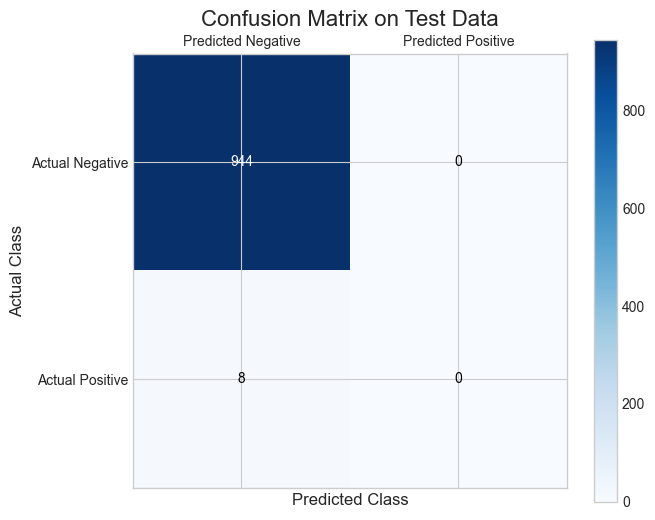


--- Calculating SHAP values for model explainability... ---
✅ SHAP values calculated.

SHAP Summary Plot (Beeswarm):
Shows the impact of each feature on the model's output for every sample.
Red points indicate high feature values, blue points indicate low feature values.


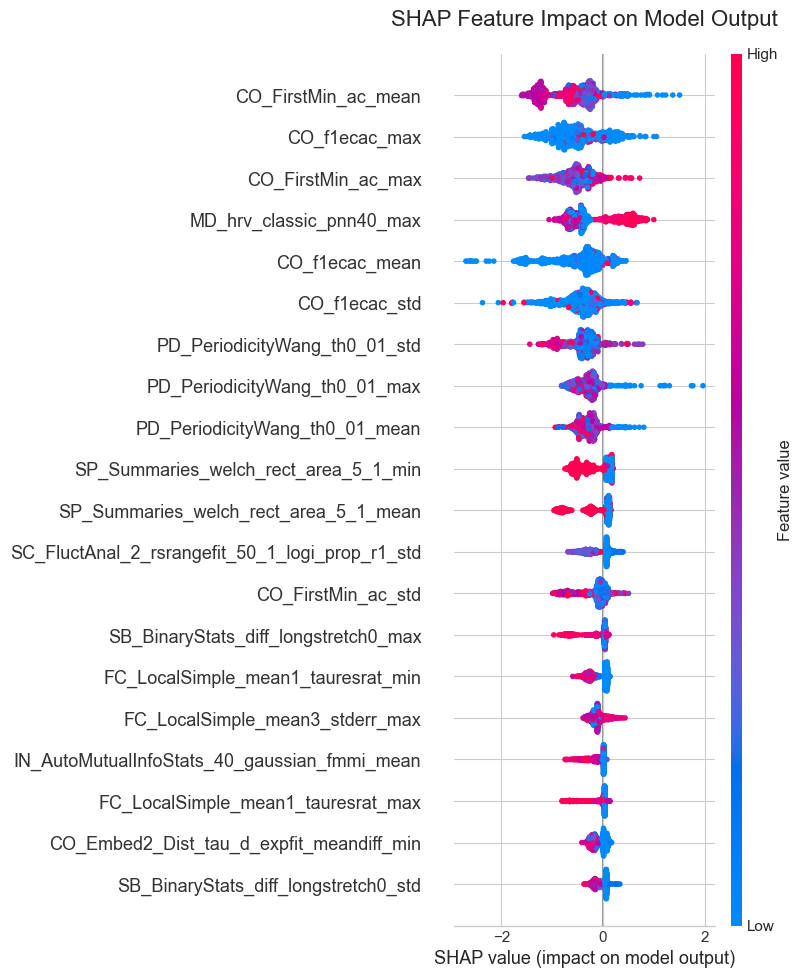


SHAP Bar Plot:
Ranks features by their mean absolute impact on the model's predictions.


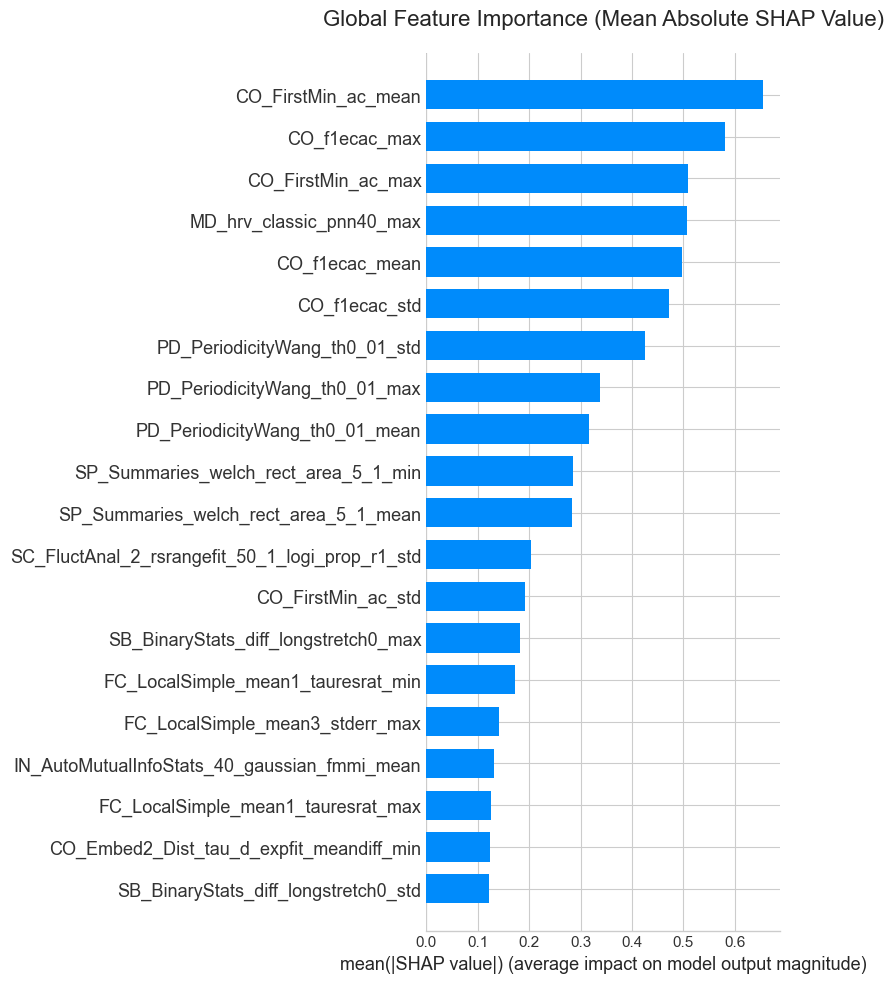

In [2]:
# =============================================================================
# XGBoost Performance Metrics & SHAP Feature Importance
#
# This script is designed for a Jupyter Notebook environment. It performs the
# following steps:
# 1. Loads a pre-processed dataset.
# 2. Takes a user-defined set of optimized hyperparameters.
# 3. Splits data into training and testing sets.
# 4. Trains a final XGBoost model on the full training set.
# 5. Calculates and displays detailed performance metrics (AUROC, AUPRC, etc.)
#    on the held-out test set.
# 6. Computes SHAP values to explain model predictions and generates plots
#    for feature importance.
# =============================================================================

# --- Cell 1: Imports and Setup -----------------------------------------------
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Scikit-learn for data processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Model & Explainability
import xgboost as xgb
import shap

# Notebook-specific settings for better display
# The line below is a "magic command" for Jupyter to display plots inline
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Use a matplotlib style for gridlines
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("--- Libraries imported successfully ---")


# --- Cell 2: Configuration and Hyperparameters -------------------------------
# Define file paths and global constants
INPUT_CSV = "waveform_catch22_features_sliding_window.csv"
TARGET_COLUMN = "death_label"
RANDOM_STATE = 42

# Define project paths.
# This assumes your notebook is in a 'notebooks' directory
# and your data is in a parallel 'data/processed' directory.
# Adjust the path if your project structure is different.
try:
    PROJECT_ROOT = Path.cwd().parent
    PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
except Exception:
    # Fallback for environments where .parent might not work as expected
    PROCESSED_DIR = Path("./data/processed")


# =============================================================================
# ▼▼▼ PASTE YOUR OPTIMIZED HYPERPARAMETERS HERE ▼▼▼
# =============================================================================
hpo_params_xgboost = {
    'n_estimators': 1900,
    'learning_rate': 0.050261234879138424,
    'max_depth': 5,
    'subsample': 0.962900236233294,
    'colsample_bytree': 0.6334346307178358,
    'gamma': 2.0082773485610845,
    'reg_lambda': 5.324822059047732e-07,
    'reg_alpha': 5.6977430992216505e-08,
    'scale_pos_weight': 117.90625,
}
# =============================================================================

# Add other necessary fixed parameters for the model
hpo_params_xgboost.update({
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "aucpr",
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": RANDOM_STATE,
})

print("\n--- Configuration and hyperparameters are set ---")
print(f"Attempting to load data from: {PROCESSED_DIR / INPUT_CSV}")


# --- Cell 3: Data Loading and Preparation ------------------------------------
try:
    df = pd.read_csv(PROCESSED_DIR / INPUT_CSV).dropna()
    X = df.drop(columns=["caseid", TARGET_COLUMN])
    y = df[TARGET_COLUMN]
    print("\n--- Data loaded successfully ---")
    print(f"Dataset shape: {df.shape}")

    # --- Train/Test Split & Scaling ---
    # Use a stratified 80/20 split for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # Scale features: fit on training data, transform both train and test
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    print("\n--- Data split and scaled ---")
    print(f"X_train shape: {X_train_s.shape}")
    print(f"X_test shape:  {X_test_s.shape}")

except FileNotFoundError:
    print(f"\n❌ ERROR: Data file not found. Please check the path.")
    print("Execution cannot continue without data.")
    # Set X to None to prevent subsequent cells from running with errors
    X = None


# --- Cell 4: Model Training --------------------------------------------------
if X is not None:
    print("\n--- Training final XGBoost model with optimized parameters... ---")
    model = xgb.XGBClassifier(**hpo_params_xgboost)
    model.fit(X_train_s, y_train)
    print("✅ Model training complete.")


# --- Cell 5: Performance Evaluation on Test Set ------------------------------
if X is not None:
    print("\n--- Evaluating model performance on the test set... ---")
    # Generate predictions
    y_pred_proba = model.predict_proba(X_test_s)[:, 1] # Probabilities for the positive class
    y_pred_class = model.predict(X_test_s)            # Class predictions (0 or 1) using 0.5 threshold

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class, zero_division=0)
    sensitivity = recall_score(y_test, y_pred_class) # Sensitivity is the same as Recall
    f1 = f1_score(y_test, y_pred_class)

    # Specificity requires values from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Display results in a DataFrame
    metrics_df = pd.DataFrame({
        'Metric': [
            'AUROC', 'AUPRC', 'Accuracy', 'Precision',
            'Sensitivity (Recall)', 'Specificity', 'F1-Score'
        ],
        'Score': [auroc, auprc, accuracy, precision, sensitivity, specificity, f1]
    })

    print("\n📊 Model Performance on Test Set")
    display(metrics_df.round(4))

    # Plot Confusion Matrix using Matplotlib
    cm = confusion_matrix(y_test, y_pred_class)
    fig, ax = plt.subplots(figsize=(7, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Define class labels
    classes = ['Negative', 'Positive']
    
    # Add annotations
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > threshold else "black")

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels([f'Predicted {label}' for label in classes])
    ax.set_yticklabels([f'Actual {label}' for label in classes])

    plt.title('Confusion Matrix on Test Data', fontsize=16, pad=20)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.show()


# --- Cell 6: SHAP Feature Importance Analysis --------------------------------
if X is not None:
    print("\n--- Calculating SHAP values for model explainability... ---")
    # SHAP (SHapley Additive exPlanations) provides insights into feature contributions.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_s)
    print("✅ SHAP values calculated.")

    # Generate SHAP Summary Plot (Beeswarm)
    print("\nSHAP Summary Plot (Beeswarm):")
    print("Shows the impact of each feature on the model's output for every sample.")
    print("Red points indicate high feature values, blue points indicate low feature values.")
    shap.summary_plot(
        shap_values,
        X_test_s,
        feature_names=X.columns,
        show=False
    )
    plt.title("SHAP Feature Impact on Model Output", fontsize=16, pad=20)
    plt.show()

    # Generate SHAP Bar Plot (Global Feature Importance)
    print("\nSHAP Bar Plot:")
    print("Ranks features by their mean absolute impact on the model's predictions.")
    shap.summary_plot(
        shap_values,
        X_test_s,
        feature_names=X.columns,
        plot_type="bar",
        show=False
    )
    plt.title("Global Feature Importance (Mean Absolute SHAP Value)", fontsize=16, pad=20)
    plt.show()
